In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")

In [6]:
from langchain_core.messages import AIMessage, HumanMessage
from pprint import pprint

messages=[AIMessage(content=f"Please tell me how can i help", name="LLMModel")]
messages.append(HumanMessage(content=f"i want to learn coding", name="Rajesh"))
messages.append(AIMessage(content=f"Which programming language you want to learn", name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn python", name="Rajesh"))

for message in messages:
    message.pretty_print()


================================== Ai Message ==================================
Name: LLMModel

Please tell me how can i help
================================ Human Message =================================
Name: Rajesh

i want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn
================================ Human Message =================================
Name: Rajesh

I want to learn python


In [9]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="deepseek-r1-distill-llama-70b")
result=llm.invoke(messages)
result.response_metadata

{'token_usage': {'completion_tokens': 1765,
  'prompt_tokens': 32,
  'total_tokens': 1797,
  'completion_time': 6.418181818,
  'prompt_time': 0.002106653,
  'queue_time': 0.052335607,
  'total_time': 6.420288471},
 'model_name': 'deepseek-r1-distill-llama-70b',
 'system_fingerprint': 'fp_1bbe7845ec',
 'finish_reason': 'stop',
 'logprobs': None}

In [10]:
result

AIMessage(content='<think>\nAlright, the user initially asked how they could help, which is pretty broad. I responded by asking which programming language they wanted to learn. They chose Python, which is a great choice for beginners because it\'s user-friendly and versatile.\n\nNow, looking at their latest query, "I want to learn python," I need to provide a structured and encouraging response. They\'re probably just starting out, so I should make the information easy to digest.\n\nFirst, I should explain why Python is a good choice. It\'s important to build their confidence and show that they made the right decision. Next, I\'ll outline the steps they need to take. Starting with the basics makes sense, so I\'ll break it down into sections like syntax, variables, control flow, functions, data structures, file handling, and OOP concepts.\n\nIncluding resources is crucial. They might not know where to start, so suggesting textbooks, online courses, websites, and YouTube channels can gui

In [15]:

def add(a:int, b:int)-> int:
    """ Add a and b
    Args:
       a (int): first int
       b (int): second int
    Returns:
       int
    """
    return a+b

In [17]:
###Binding tools wigth tool
llm_with_tools=llm.bind_tools([add])
tool_call=llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 2",name="Rajesh")])
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'ytw0yyftd',
  'type': 'tool_call'}]

In [ ]:
### Using messages as State

In [49]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

### Reducers with add messages

In [29]:
initial_messages=[AIMessage(content=f"Please tell me how can i help", name="LLMModel")]
initial_messages.append(HumanMessage(content=f"i want to learn coding", name="Rajesh"))
initial_messages

[AIMessage(content='Please tell me how can i help', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='i want to learn coding', additional_kwargs={}, response_metadata={}, name='Rajesh')]

In [31]:
ai_messages=(AIMessage(content=f"Which programming language you want to learn", name="LLMModel"))
ai_messages


AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [32]:
### Reducers append instead of override
add_messages(initial_messages, ai_messages)

[AIMessage(content='Please tell me how can i help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='821aab19-19bb-47bb-a8f8-6804bcb882ea'),
 HumanMessage(content='i want to learn coding', additional_kwargs={}, response_metadata={}, name='Rajesh', id='406de3da-6238-409f-9946-60c3c5dd7176'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='5a058cea-8789-43a4-a498-220de53b18e1')]

In [50]:
###Chatbot node functionality
def llm_tool(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

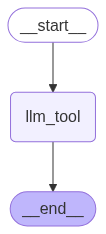

In [51]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
builder = StateGraph(State)

builder.add_node("llm_tool", llm_tool)
builder.add_edge(START, "llm_tool")
builder.add_edge("llm_tool", END)

workflow=builder.compile()
display(Image(workflow.get_graph().draw_mermaid_png()))



In [54]:
result = workflow.invoke({"messages": [HumanMessage(content="what is 2 plus 2")]})
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (mtawxhmns)
 Call ID: mtawxhmns
  Args:
    a: 2
    b: 2


In [55]:
tools=[(add)]

In [56]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

builder=StateGraph(State)
## Add nodes

builder.add_node("llm_tool", llm_tool)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "llm_tool")
builder.add_conditional_edges("llm_tool", tools_condition)
builder.add_edge("tools", END)

graph_builder=builder.compile()


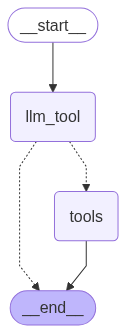

In [58]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [62]:
## invocation

messages=graph_builder.invoke({"messages": "what is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (hndewyp4t)
 Call ID: hndewyp4t
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [63]:
## invocation

messages=graph_builder.invoke({"messages": "what machine learning"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what machine learning
================================== Ai Message ==================================

Machine learning is a subset of artificial intelligence (AI) that involves the use of algorithms and statistical models to enable machines to perform a specific task without using explicit instructions, instead relying on patterns and inference from data. In simpler terms, machine learning allows systems to learn from data and improve their performance on a task over time.

### Key Concepts in Machine Learning:
1. **Types of Machine Learning:**
   - **Supervised Learning:** The model is trained on labeled data (data with known outputs) to learn the mapping between inputs and outputs.
   - **Unsupervised Learning:** The model is trained on unlabeled data and aims to find patterns or intrinsic structures in the data.
   - **Reinforcement Learning:** The model learns by interacting with an environment and 